# Self-Supervised Vision Transformer for Land Cover Segmentation: Swin Transformer + Sentinel-1/2

This notebook is an adaptation of a demo originally presented by Linus Scheibenreif, Joëlle Hanna, at the [University of St.Gallen, School of Computer Science, AIML Lab](https://ics.unisg.ch/chair-aiml-borth/). Originally designed for a classification task, this notebook has been modified for a segmentation task.

The notebook contains code for fine-tuning pretrained Swin Transformer backbones as introduced in their work. It utilizes two backbones, one processing Sentinel-1 SAR data and the other handling Sentinel-2 multi-band imagery. These backbones are combined to address the segmentation task. In this example, we aim to fine-tune the Swin Transformer backbones for an image segmentation task, using both Sentinel-1 and Sentinel-2 data from the DFC2020 dataset.

This implementation is based on the paper:

[Linus Scheibenreif, Joëlle Hanna, Michael Mommert, Damian Borth, *Self-Supervised Vision Transformers for Land-Cover Segmentation and Classification*, Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR) Workshops, 2022, pp. 1422-1431](https://openaccess.thecvf.com/content/CVPR2022W/EarthVision/html/Scheibenreif_Self-Supervised_Vision_Transformers_for_Land-Cover_Segmentation_and_Classification_CVPRW_2022_paper.html)

## Content

1. [Installation](#installation)
1. [Dataset](#dataset)
1. [Quick Start](#quickstart)

<a id='installation'></a>
## 1. Installation

#### Dependencies

This project uses Python 3.8, and the dependencies listed in `requirements.txt` can be installed with `pip` or `conda`, in a virtual environment. For example, using `pip`:


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
path_to_module_1 = '/content/drive/My Drive/Projet Computer Vision/LandCover_map_Transformers_SSL/src'
sys.path.append(path_to_module_1)

In [3]:
!pip install wandb
!pip install rasterio
!pip install timm
!pip install einops
!pip install diffdist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 860.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for diffdist: filename=diffdist-0.1-py3-none-any.whl size=6534 sha256=fcb7a8f84a68a6ebc59ca3e4a98cc03ec3bab9d6c44dc45aaa9b7abf58e0dfcb
  Stored in directory: /root/.cache/pip/wheels/f1/29/f6/5331a14ab74e769799b76eb32460f447c7feb7375a16b07854
Successfully built diffdist


In [4]:
# Import needed packages
import argparse
import json
import os
import random
import numpy as np
import torch
import wandb
import torch.nn.functional as F
from distutils.util import strtobool
from tqdm import tqdm
from torchvision.models import resnet18, resnet50
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
import os
from pathlib import Path

import sys
sys.path.append('../..')
from tools.dfc_dataset import DFCDataset
from Transformer_SSL.models.swin_transformer import DoubleSwinTransformerDownstream
from tools.utils import save_checkpoint_single_model, dotdictify, print_metrics_acc, print_metrics
from Transformer_SSL.models import build_model
from Transformer_SSL.models.swin_transformer import SwinTransformerDecoder

<a id='dataset'></a>
## 2. Dataset


#### Download

 In this notebook, we will use the DFC2020 dataset to train downstream tasks. You can download it using this [link](https://ieee-dataport.org/competitions/2020-ieee-grss-data-fusion-contest). We are using multimodal input here (fusion of Sentinel-1 and Sentinel-2)


#### Configure

For example, in the `data_config` dictionary (cell below), you can specify paths to the data directory with `train_dir` and `val_dir` or the image input size with `image_px_size`.

In [5]:
# Data configurations:
data_config = {
    'train_dir': '/content/drive/My Drive/train', # path to the training directory,
    'val_dir': '/content/drive/My Drive/val', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 8, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

In [41]:
random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

#### Prepare

We create the `train_dataset` and `val_dataset` by using the `DFCDataset`, a custom class of `torch.utils.data.Dataset`

In [7]:
# Create Training Dataset
train_dataset = DFCDataset(
    data_config['train_dir'],
    mode=data_config['train_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['train_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_train'],
    seed=data_config['seed']
)

# Create Validation Dataset
val_dataset = DFCDataset(
    data_config['val_dir'],
    mode=data_config['val_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['val_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_validation'],
    seed=data_config['seed']
)

We can see how many examples are in each split by checking their length:

In [8]:
len(train_dataset), len(val_dataset)

(986, 5128)

We can also display some examples:

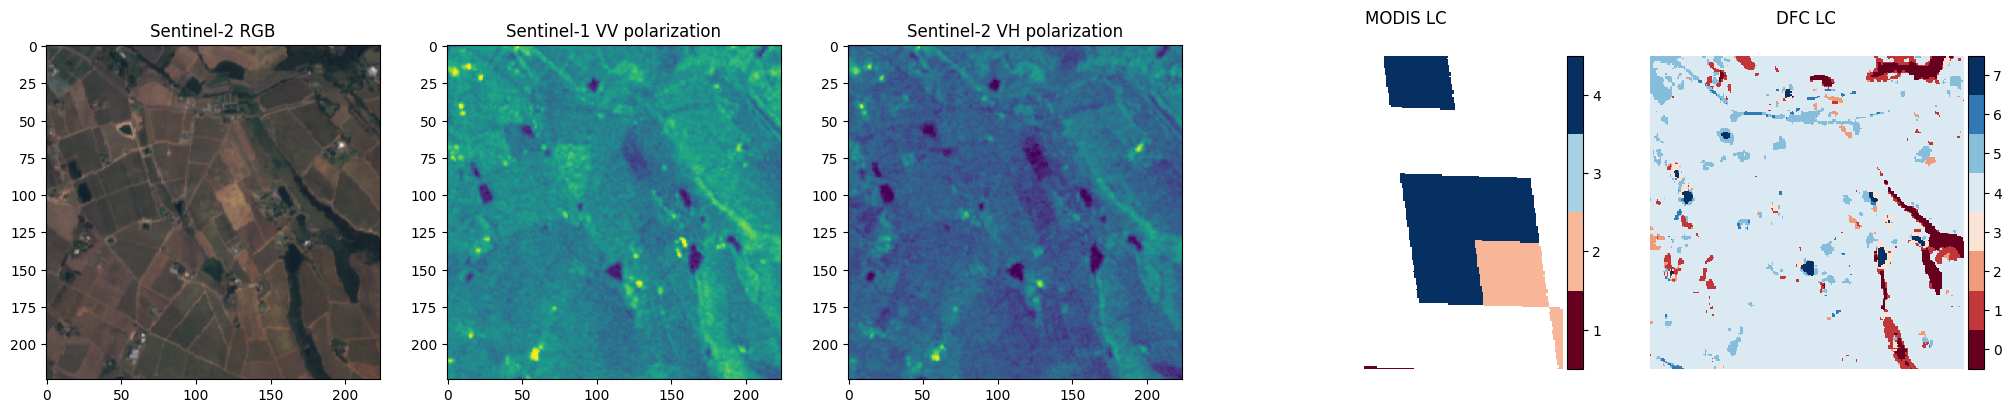

In [9]:
train_dataset.visualize_observation(67)

The plots show, from left to right: Sentinel-2 true color image, Sentinel-1 maps for the two different polarizations, a coarse MODIS LULC map and the high-resolution DFC2020 LULC map.

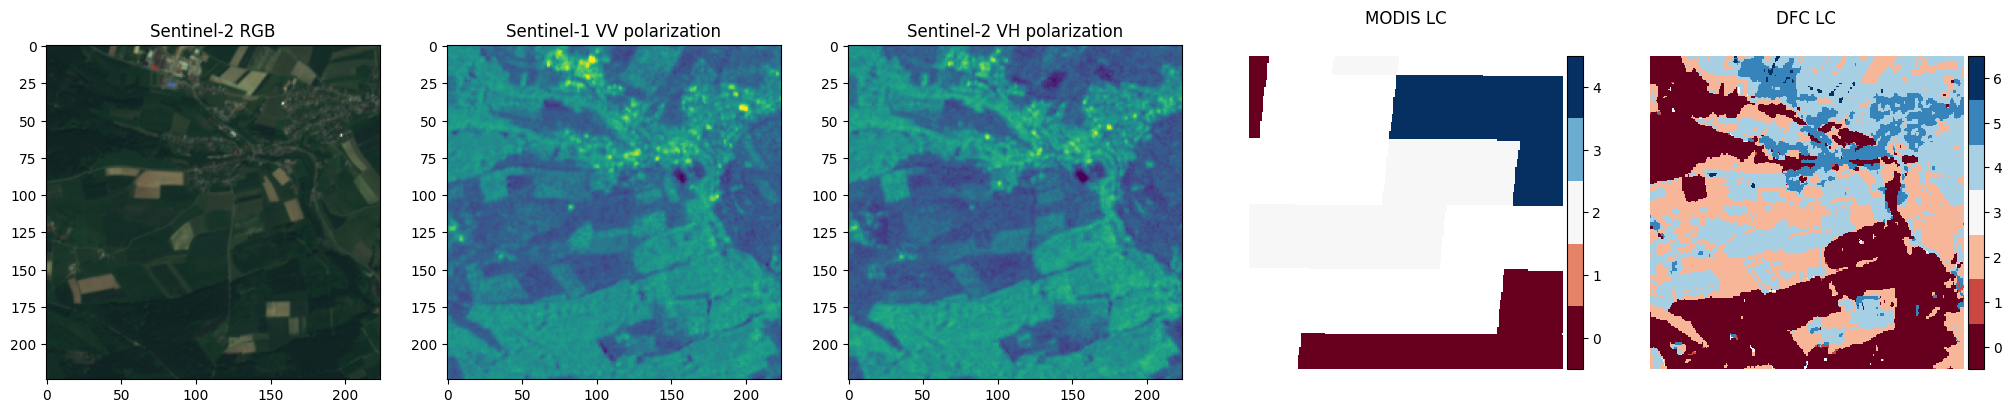

In [10]:
val_dataset.visualize_observation(89)

We define a correspondance of label and names:

In [11]:
DFC_map_clean = {
    0: "Forest",
    1: "Shrubland",
    2: "Grassland",
    3: "Wetlands",
    4: "Croplands",
    5: "Urban/Built-up",
    6: "Barren",
    7: "Water",
    255: "Invalid",
}

Our data is now ready to be used by the model. In the next section we load and configure the model.

<a id='quickstart'></a>
## 3. Quick Start

#### Configure

You can specify in the some hyperparameters in `train_config` (cell below), such as the `learning_rate`, the `batch_size`, number of `epochs`, or if you wish to fine-tune the model or not (with the `finetuning` argument), etc.

In [12]:
# Training configurations
train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': False, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999),
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 8,
    'epochs': 30,
    'target': 'dfc'
}

#### Download checkpoint

You can download the pre-trained backbone model using this [link](https://drive.google.com/file/d/1e7QhC2-zoBFgb65yN1ADWBZLMShHOweY/view), save it in the `checkpoints/` directory then run the following cell.

Make sure to properly modify the path to the downloaded checkpoint in the path below.

In [13]:
# path to the checkpoint
checkpoint = torch.load(
    "/content/drive/My Drive/Projet Computer Vision/swin_t.pth", map_location=torch.device('cpu')
)
weights = checkpoint["state_dict"]

# Sentinel-1 stream weights
s1_weights = {
    k[len("backbone1."):]: v for k, v in weights.items() if "backbone1" in k
}

# Sentinel-2 stream weights
s2_weights = {
    k[len("backbone2."):]: v for k, v in weights.items() if "backbone2" in k
}

#### Prepare model and load checkpoint

We prepare the model by specifying the `input_channels`: sentinel1 and sentinel2 . We also specify if we need both backbones `s1_backbone` and `s2_backbone`.

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")

# Input channel size
input_channels = train_config['s1_input_channels'] + train_config['s2_input_channels']


with open("/content/drive/My Drive/Projet Computer Vision/LandCover_map_Transformers_SSL/src/configs/backbone_config.json", "r") as fp:
    swin_conf = dotdictify(json.load(fp))

s1_backbone = build_model(swin_conf.model_config)

swin_conf.model_config.MODEL.SWIN.IN_CHANS = 13
s2_backbone = build_model(swin_conf.model_config)

s1_backbone.load_state_dict(s1_weights)
s2_backbone.load_state_dict(s2_weights)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

We create the downstream model head that will be trained. . Our segmentor takes as input the pre-trained backbone (in the form of two streams `encoder1` and `encoder2`), the `out_dim` (number of classes), and `freeze_layers` flag, specifying whether you wish to freeze the backbone weights or not.

In [15]:
class DoubleSwinTransformerSegmentation(nn.Module):
    def __init__(self, encoder1, encoder2, out_dim, device, freeze_layers=False):
        super(DoubleSwinTransformerSegmentation, self).__init__()

        self.device = device

        self.backbone1 = encoder1
        self.backbone2 = encoder2

        self.decoder1 = SwinTransformerDecoder(self.backbone1, out_dim, device)
        self.decoder2 = SwinTransformerDecoder(self.backbone2, out_dim, device)

        # freeze all backbone layers
        if freeze_layers:
            for name, param in self.named_parameters():
                if name.startswith(('backbone')):
                    param.requires_grad = False

    def forward(self, x):
        _, x2, x_seg2 = self.backbone2.forward_features(x["s2"].to(self.device))
        _, x1, x_seg1 = self.backbone1.forward_features(x["s1"].to(self.device))

        x1 = self.decoder1.forward_up_features(x1, x_seg1)
        x2 = self.decoder2.forward_up_features(x2, x_seg2)

        x = torch.cat([x1, x2], dim=-1)

        output = self.decoder1.up_x4(x)

        return output

In [16]:
model = DoubleSwinTransformerSegmentation(s1_backbone, s2_backbone, device=device,
                                              out_dim=data_config['num_classes'])

model = model.to(device)

Define and initialise the loss for training. Here we are training for single-class classification and using a `torch.nn.CrossEntropyLoss` loss.

In [17]:
#criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)

In [18]:
class ConfMatrix():

    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.state = np.zeros((self.num_classes, self.num_classes))

    def calc(self, gt, pred):
        """ calcs and returns the CM without saveing it to state """
        return confusion_matrix(gt.flatten(),
                                pred.flatten(),
                                labels=np.arange(self.num_classes))

    def get_existing_classes(self):
        return sum(np.sum(self.state, axis=1) > 0)

    def add(self, gt, pred):
        """ adds one label mask to the confusion matrix """

        assert gt.shape == pred.shape
        assert gt.shape == (256, 256)

        gt = gt.flatten()
        pred = pred.flatten()
        pred = pred[gt != 255]
        gt = gt[gt != 255]

        if not gt.size == 0:
            self.state += confusion_matrix(gt, pred,
                                           labels=np.arange(self.num_classes))

        return None

    def add_batch(self, gt, pred):
        """ adds a batch of label masks to the confusion matrix """

        # convert pytorch tensors to numpy arrays
        if not isinstance(gt, np.ndarray):
            gt = gt.cpu().numpy()
            pred = pred.cpu().numpy()

        assert len(gt.shape) == 3       # assert C x W x H

        noc = gt.shape[0]               # number of channels
        for batchindex in range(noc):   # iterate over batch
            self.add(gt[batchindex], pred[batchindex])

        return None

    def norm_on_lines(self):
        """ norms along the lines of the matrix """

        a = self.state
        b = np.sum(self.state, axis=1)[:, None]
        return np.divide(a, b, out=np.zeros_like(a), where=b != 0)

    def get_aa(self):
        confmatrix = self.norm_on_lines()
        return np.diagonal(confmatrix).sum() / self.get_existing_classes()

    def get_IoU(self):
        res = np.zeros(self.num_classes)
        for i in range(self.num_classes):
            cm = self.state
            a = cm[i, i]
            b = (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
            res[i] = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
        return res

    def get_mIoU(self):
        return np.mean(self.get_IoU())


def AA(gt, pred, num_classes):
    """ This is the mean over the diagonal of the confusion
    matrix when it's normed """

    cm = ConfMatrix(num_classes)
    cm.add(gt, pred)
    confmatrix = cm.norm_on_lines()

    return np.mean(np.diagonal(confmatrix))


def IoU(gt, pred, num_classes):
    """
    the intersection over union for class i can be calculated as follows:


    get the intersection:
        >>> thats the element [i,i] of the confusion matrix (cm)

    the union:
        >>> is the sum over row with index i plus the sum over line with index
        i minux the diagonal element [i,i] (otherwise its counted twice)

    """

    cm = ConfMatrix(num_classes).calc(gt, pred)

    res = np.zeros(num_classes)
    for i in range(num_classes):
        res[i] = cm[i, i] / (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])

    return res


def mIoU(gt, pred, num_classes):
    return np.mean(IoU(gt, pred, num_classes))

class PixelwiseMetrics(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes

        # Initialize dictionaries to store class-wise statistics
        self.data = {"pixelclass_" + str(i): {"correct": 0, "total": 0} for i in range(num_classes)}

    def add_batch(self, y, y_hat):
        for c in range(self.num_classes):
            class_data = self.data["pixelclass_" + str(c)]
            preds_c = y_hat == c
            targs_c = y == c
            num_correct = (preds_c * targs_c).sum().cpu().detach().numpy()
            num_pixels = np.sum(targs_c.cpu().detach().numpy())

            # Update class-wise statistics
            class_data["correct"] += num_correct
            class_data["total"] += num_pixels

    def get_classwise_accuracy(self):
        cw_acc_ = {k: el['correct'] / el['total'] if el['total'] > 0 else 0.0 for k, el in self.data.items()}
        return cw_acc_

    def get_average_accuracy(self):
        cw_acc = self.get_classwise_accuracy()
        return np.mean(list(cw_acc.values()))

Define the trainable parameters (needed for the optimizer):

In [19]:
if train_config['finetuning']:
    # train all parameters (backbone + classifier head)
    param_backbone = []
    param_head = []
    for p in model.parameters():
        if p.requires_grad:
            param_head.append(p)
        else:
            param_backbone.append(p)
        p.requires_grad = True
    # parameters = model.parameters()
    parameters = [
        {"params": param_backbone},  # train with default lr
        {
            "params": param_head,
            "lr": train_config['classifier_lr'],
        },  # train with classifier lr
    ]
    print("Finetuning")

else:
    # train only final linear layer for SSL methods
    print("Frozen backbone")
    parameters = list(filter(lambda p: p.requires_grad, model.parameters()))

Frozen backbone


Initialise the selected optimizer. In this work we chose Adam optimizer. You can initialise any optimizer you want.

In [20]:
optimizer = torch.optim.Adam(
    parameters,
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

We load the data (training and validation) using pytorch's dataloader

In [21]:
# Define the path for saving the model
model_save_path = '/content/drive/My Drive/Checkpoints/SSL_SwinUnet_S1_S2_30.pth'

In [22]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=train_config['dataloader_workers'],
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Everything is set and we are now ready to train the segmentor head:

In [23]:
num_classes = data_config['num_classes']

def train_segmentation_model(epochs, train_loader, val_loader, model, optimizer, criterion, num_classes):
    for epoch in range(epochs):
        # Phase d'entraînement
        model.train()
        train_losses, train_metrics = [], PixelwiseMetrics(num_classes)

        for sample in tqdm(train_loader):
            if "x" in sample.keys():
                if torch.isnan(sample["x"]).any():
                    continue
            else:
                if torch.isnan(sample["s1"]).any() or torch.isnan(sample["s2"]).any():
                    continue

            s1 = sample["s1"].to(device)
            s2 = sample["s2"].to(device)
            img = {"s1": s1, "s2": s2}

            y = sample[train_config['target']].long().to(device)
            y = torch.squeeze(y, 1)

            optimizer.zero_grad()
            y_hat = model(img)

            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            pred = torch.argmax(y_hat, dim=1)
            train_metrics.add_batch(y, pred)

        # Calculer les statistiques d'entraînement
        train_loss = np.mean(train_losses)
        train_acc = train_metrics.get_average_accuracy()

        # Phase de validation
        if (epoch + 1) % 29 == 0:
            model.eval()
            val_losses, val_metrics = [], PixelwiseMetrics(num_classes)
            with torch.no_grad():
                for sample in tqdm(val_loader):
                    if "x" in sample.keys():
                        if torch.isnan(sample["x"]).any():
                            continue
                    else:
                        if torch.isnan(sample["s1"]).any() or torch.isnan(sample["s2"]).any():
                            continue

                    s1 = sample["s1"].to(device)
                    s2 = sample["s2"].to(device)
                    img = {"s1": s1, "s2": s2}

                    y = sample[train_config['target']].long().to(device)
                    y = torch.squeeze(y, 1)

                    y_hat = model(img)

                    loss = criterion(y_hat, y)

                    val_losses.append(loss.item())
                    pred = torch.argmax(y_hat, dim=1)
                    val_metrics.add_batch(y, pred)

            # Calculer les statistiques de validation
            val_loss = np.mean(val_losses)
            val_acc = val_metrics.get_average_accuracy()

            # Imprimer les statistiques
            print(f'Epoch {epoch}: Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

            # Sauvegarder le modèle
            if (epoch + 1) % 29 == 0:
              os.makedirs(os.path.dirname(model_save_path), exist_ok=True)  # Ensure the directory exists
              torch.save(model.state_dict(), model_save_path)
              print(f"Best model saved to {model_save_path}.")


In [24]:
train_segmentation_model(train_config['epochs'], train_loader, val_loader, model, optimizer, criterion, num_classes)

100%|██████████| 641/641 [1:40:10<00:00,  9.38s/it]


Epoch 28: Train Loss: 0.4722667465046529, Train Acc: 0.760734594159429, Val Loss: 1.0958299765627768, Val Acc: 0.4724845898851553
Best model saved to /content/drive/My Drive/Checkpoints/SSL_SwinUnet_S1_S2_30.pth.


100%|██████████| 124/124 [02:25<00:00,  1.17s/it]


You can evaluate the model on one example by creating a model's instance, loading checkpoint's weights of the classifier saved during training, running it, and displaying the results:

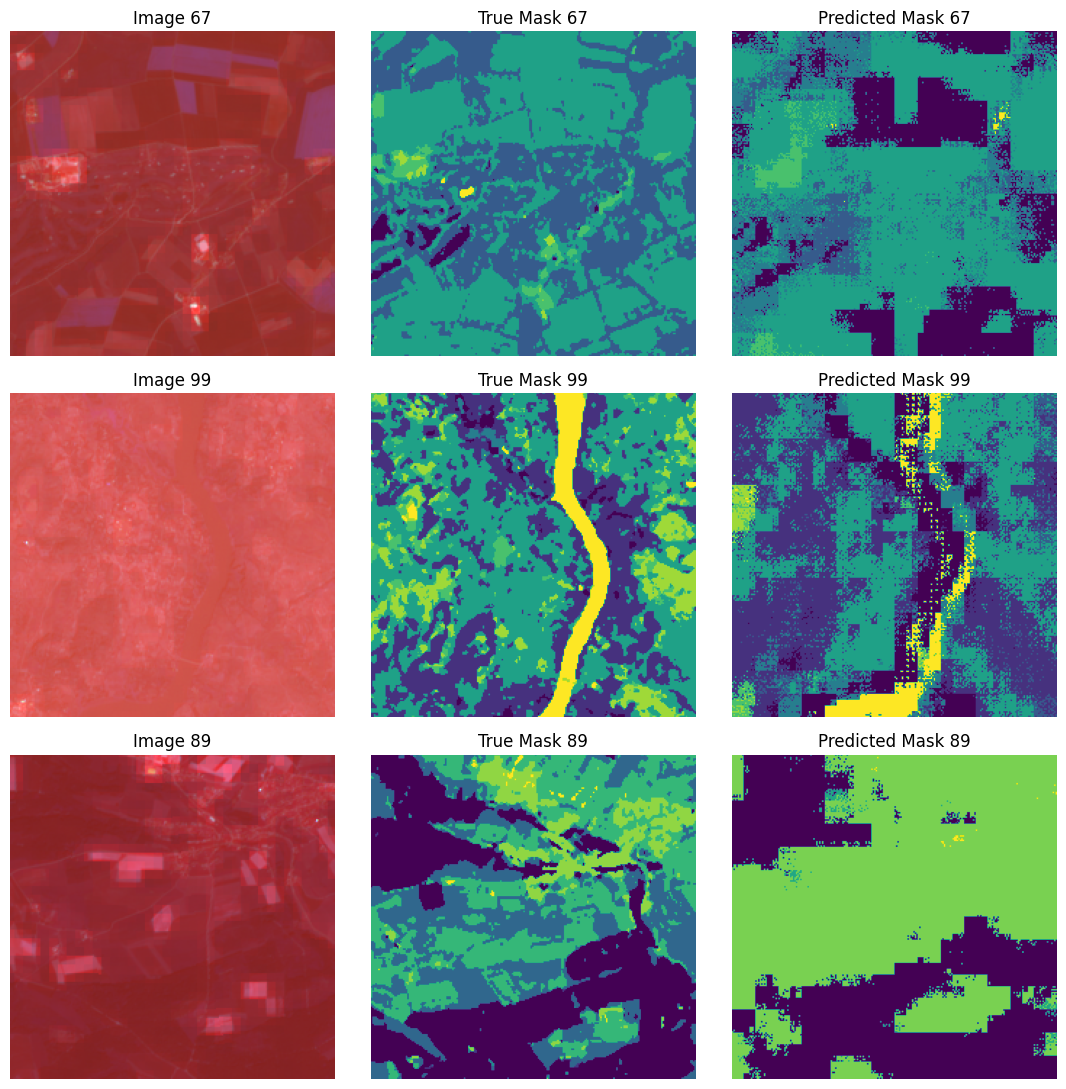

In [44]:
# Create a new instance of the model
model = DoubleSwinTransformerSegmentation(s1_backbone, s2_backbone, device=device,
                                              out_dim=data_config['num_classes'], freeze_layers=False)

model = model.to(device)

# Load checkpoint weights
model.load_state_dict(torch.load(model_save_path))

# Prepare the input and feed it to the model for evaluation

indices = [67, 99, 89]

# Create a subplot grid
fig, axes = plt.subplots(3, 3, figsize=(11,11))

for i, idx in enumerate(indices):
    # Prepare the input
    img = {
    "s1": torch.unsqueeze(val_dataset[idx]['s1'], 0),
    "s2": torch.unsqueeze(val_dataset[idx]['s2'], 0)
    }

    true_mask = val_dataset[idx][train_config['target']].squeeze(0)
    model.eval()
    # Get the model output
    output = model(img)
    output = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Display the image
    axes[i, 0].imshow(img["s2"].squeeze(0)[:3,:,:].permute(1, 2, 0).cpu().numpy())
    axes[i, 0].set_title(f'Image {idx}')
    axes[i, 0].axis('off')

    # Display the true mask
    axes[i, 1].imshow(true_mask)
    axes[i, 1].set_title(f'True Mask {idx}')
    axes[i, 1].axis('off')

    # Display the predicted mask
    axes[i, 2].imshow(output)
    axes[i, 2].set_title(f'Predicted Mask {idx}')
    axes[i, 2].axis('off')

# Show the plots
plt.tight_layout()
plt.show()


In [46]:
def predict_and_save(val_dataset, save_path, model, device='cuda'):
    """
    Function to perform predictions on a test dataset and save the results.

    Args:
        test_loader (DataLoader): DataLoader for the test dataset.
        save_path (str): Path where to save the prediction results.
        model (torch.nn.Module): Pre-trained model for making predictions.
        device (str): Device to run the predictions on ('cuda' or 'cpu').
    """
    model.eval()
    model.to(device)

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    with torch.no_grad():
        for i in range(len(val_dataset)):
            img = {
                  "s1": torch.unsqueeze(val_dataset[i]['s1'], 0),
                  "s2": torch.unsqueeze(val_dataset[i]['s2'], 0)
                  }
            outputs = model(img)

            # Apply argmax to get the most probable class for each pixel
            predicted = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()

            # Ensure prediction is a 2D array
            if predicted.ndim != 2:
                raise ValueError(f"Predicted image is not 2D: {predicted.shape}")

            save_file_path = os.path.join(save_path, f'prediction_{i}.npy')
            np.save(save_file_path, predicted)

    print("Predictions successfully saved.")


In [47]:
pred_msk  = '/content/drive/My Drive/Projet Computer Vision/pred_SSL_S1_S2_Frozen'

In [48]:

predict_and_save(val_dataset, pred_msk, model, device='cuda')

Predictions successfully saved.


In [49]:
def generate_miou(test_dataset, path_pred: str, S: str) -> tuple:
    def get_data_paths(path, filter):
        for path in Path(path).rglob(filter):
            yield path.resolve().as_posix()

    def calc_miou(cm_array):
        if cm_array.ndim != 2:
            raise ValueError(f"Confusion matrix is not 2D: {cm_array.shape}")
        ious = np.diag(cm_array) / (cm_array.sum(0) + cm_array.sum(1) - np.diag(cm_array))
        m = np.nanmean(ious[:-1])
        return m, ious[:-1]

    preds_images = sorted(list(get_data_paths(Path(path_pred), 'prediction*.npy')), key=lambda x: int(x.split('_')[-1][:-4]))

    if len(test_dataset) != len(preds_images):
        print('[WARNING !] Mismatch number of predictions and test files.')
    fr = 0
    patch_confusion_matrices = []
    for u in range(len(test_dataset)):

        preds = np.load(preds_images[u])
        if preds.ndim != 2:
            raise ValueError(f"Prediction image is not 2D: {preds.shape}")

        cm = confusion_matrix(test_dataset[u][S].flatten(), preds.flatten(), labels=list(range(13)))
        patch_confusion_matrices.append(cm)

    sum_confmat = np.sum(patch_confusion_matrices, axis=0)
    if sum_confmat.ndim != 2:
        raise ValueError(f"Summed confusion matrix is not 2D: {sum_confmat.shape}")

    mIou, ious = calc_miou(sum_confmat)
    return mIou, ious

In [51]:
mIou, ious = generate_miou(val_dataset, pred_msk, S = 'dfc')
print_metrics(mIou, ious)



----------------------------------------
         Model mIoU :  0.3179
----------------------------------------
Class                     iou            
----------------------------------------
Forest                    0.43300960339187555
Shrubland                 0.14598814895821313
Grassland                 0.03710250236566026
Wetlands                  0.043976745702734556
Croplands                 0.3300268854736827
Urban/Built-up            0.4649119825945376
Barren                    0.15750980173800846
Water                     0.9305490761665667
Invalid                   nan            





<ipython-input-49-ba78110a2f79>:12: RuntimeWarning: invalid value encountered in divide
  ious = np.diag(cm_array) / (cm_array.sum(0) + cm_array.sum(1) - np.diag(cm_array))


In [54]:
def calculate_accuracy(conf_matrix):
    """Calculate classwise and overall accuracy from the confusion matrix."""
    classwise_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    overall_accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
    return classwise_accuracy, overall_accuracy

def generate_metrics_acc(test_dataset, path_pred: str, S: str) -> dict:
    def get_data_paths(path, filter):
        for path in Path(path).rglob(filter):
            yield path.resolve().as_posix()

    preds_images = sorted(list(get_data_paths(Path(path_pred), 'prediction*.npy')), key=lambda x: int(x.split('_')[-1][:-4]))

    if len(test_dataset) != len(preds_images):
        print('[WARNING !] Mismatch number of predictions and test files.')

    patch_confusion_matrices = []

    for i in range(len(test_dataset)):

        preds = np.load(preds_images[i])

        # Ensure both target and preds are 2D arrays
        if  preds.ndim != 2:
            raise ValueError(f"Target or prediction image at index {i} is not 2D.")

        patch_confusion_matrices.append(confusion_matrix(test_dataset[i][S].flatten(), preds.flatten(), labels=list(range(13))))

    sum_confmat = np.sum(patch_confusion_matrices, axis=0)
    classwise_accuracy, overall_accuracy = calculate_accuracy(sum_confmat)

    return {
        "classwise_accuracy": classwise_accuracy,
        "overall_accuracy": overall_accuracy
    }

In [55]:
metrics = generate_metrics_acc(val_dataset, pred_msk, S="dfc")
classwise_accuracy = metrics["classwise_accuracy"]
overall_accuracy = metrics["overall_accuracy"]
print_metrics_acc(overall_accuracy, classwise_accuracy)



----------------------------------------
         Model Accuracy :  0.58
----------------------------------------
Class                     accuracy       
----------------------------------------
Forest                    0.5570744445053183
Shrubland                 0.38125796536865225
Grassland                 0.05220761897991531
Wetlands                  0.09945068601736726
Croplands                 0.5191649126615615
Urban/Built-up            0.6800839228072658
Barren                    0.24524483305443362
Water                     0.9705234495616282
Invalid                   nan            





<ipython-input-54-e322326379fd>:3: RuntimeWarning: invalid value encountered in divide
  classwise_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
